In [14]:
from argparse import ArgumentParser

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as vutils
from pytorch_lightning import Trainer, loggers
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

torch.manual_seed(42)

In [15]:
class Autoencoder(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.val_outputs = []

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 2, 2, 2, 1, bias=False),
            nn.BatchNorm2d(2),
            nn.LeakyReLU(True),
            nn.Conv2d(2, 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(True),
            nn.Conv2d(4, 16, 3, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(True),
            # nn.Conv2d(16, 4, 3, 1, 0, bias=False),
            # nn.BatchNorm2d(4),
            # nn.LeakyReLU(True),
        )

        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(4, 16, 3, 1, 0, bias=False),
            # nn.BatchNorm2d(16),
            # nn.ReLU(True),
            nn.ConvTranspose2d(16, 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(2),
            nn.ReLU(True),
            nn.ConvTranspose2d(2, 1, 2, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

    def prepare_data(self):
        transform = transforms.Compose(
            [
                transforms.Grayscale(),
                transforms.ToTensor(),
            ]
        )

        dataset = ImageFolder(root='/home/maxim/Documents/TestProject/archive/trainingSet', transform=transform)

        end_train_idx = int(len(dataset) - len(dataset) / 5)
        end_val_idx = int(len(dataset) - len(dataset) / 7)
        end_test_idx = len(dataset)

        self.train_dataset = Subset(dataset, range(0, end_train_idx))
        self.val_dataset = Subset(dataset, range(end_train_idx + 1, end_val_idx))
        self.test_dataset = Subset(dataset, range(end_val_idx + 1, end_test_idx))

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=32, shuffle=True, num_workers=20
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=32, num_workers=20
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=32, num_workers=20
        )

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        output = self(x)
        loss = F.mse_loss(output, x)

        logs = {"loss": loss}
        return {"loss": loss, "log": logs}

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        output = self(x)
        loss = F.mse_loss(output, x)
        logs = {"val_loss": loss}

        self.log("val_loss", loss)

        self.val_outputs.append(output[0])

        return {"val_loss": loss, "log": logs}

    def test_step(self, batch, batch_idx):
        x, _ = batch
        output = self(x)
        loss = F.mse_loss(output, x)

        plt.imshow(output.cpu().numpy()[0, 0, :, :], "gray")

        logs = {"test_loss": loss}
        return {"test_loss": loss, "log": logs}
    
    def on_validation_epoch_end(self):
        grid = vutils.make_grid(self.val_outputs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

        self.val_outputs.clear()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 700   
1 | decoder | Sequential | 668   
---------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 15, 15]               8
       BatchNorm2d-2            [-1, 2, 15, 15]               4
         LeakyReLU-3            [-1, 2, 15, 15]               0
            Conv2d-4              [-1, 4, 8, 8]              72
       BatchNorm2d-5              [-1, 4, 8, 8]               8
         LeakyReLU-6              [-1, 4, 8, 8]               0
            Conv2d-7             [-1, 16, 4, 4]             576
       BatchNorm2d-8             [-1, 16, 4, 4]              32
         LeakyReLU-9             [-1, 16, 4, 4]               0
  ConvTranspose2d-10              [-1, 4, 7, 7]             576
      BatchNorm2d-11              [-1, 4, 7, 7]               8
             ReLU-12              [-1, 4, 7, 7]               0
  ConvTranspose2d-13            [-1, 2, 15, 15]              72
      BatchNorm2d-14            [-1, 2,

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/maxim/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{}]

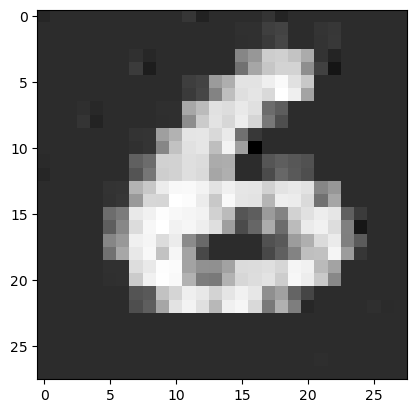

In [19]:
from pytorch_lightning.callbacks import EarlyStopping
from torchsummary import summary

model = Autoencoder()

summary(model.cuda(), (1, 28, 28), device="cuda")
        
trainer = Trainer(max_epochs=100, callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
trainer.fit(model)
trainer.test(model)


In [17]:
transform = transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]
)

dataset = ImageFolder(root='/home/maxim/Documents/TestProject/archive/testSample', transform=transform)


test_dataset = Subset(dataset, range(0, dataset.__len__()))

data = DataLoader(
            test_dataset, batch_size=32, shuffle=True, num_workers=20
        )

In [18]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 65764), started 0:12:45 ago. (Use '!kill 65764' to kill it.)